In [ ]:
code inspiration: https://medium.com/@chaudhurysrijani/tuning-of-adaboost-with-computational-complexity-8727d01a9d20

In [ ]:
# REMOVE UNNECESSARY DEPENDENCIES BEFORE FINAL REPORT

# import dependencies
import pandas as pd
import numpy as np
import nltk
import re
import itertools
import matplotlib.pyplot as plt

## nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag

## sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

## joblib
from joblib import dump, load

# set seed
np.random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# load data 
train = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Train.csv', header=0)
val = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Val.csv', header=0)

# REMOVE 'ID' FEATURE FROM DATASET? IS THE ML ALGORITHM BEING TRAINED ON THE 'ID'? IF SO, THIS IS USELESS NOISE THAT SHOULD BE REMOVED...
# SHOULD WE RELABEL THE 'TWEET' TO SOMETHING THAT MORE ACCURATELY REPRESENTS THE DATA, FOR EXAMPLE 'CLAIM' OR 'STATEMENT'? 'TWEET' MAY BE MISLEADING SINCE OUR DATA ISN'T ONLY COMPRISED OF TWEETS

In [ ]:
# CONVERT "REAL" AND "FAKE" LABELS TO 0 AND 1 TO MAKE THEM MACHINE READABLE
# word_tokens = word_tokenize()
# ps = PorterStemmer() # creating an instance of PorterStemmer class

stop_words = set(stopwords.words("english")) # create list of stop words
def cleantext(string):
    text = string.lower().split() # convert letters to lowercase and split claims ('tweets') into separate words
    text = " ".join(text) # ???
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text) # replace '&' with ' and '
    text = text.replace('&amp',' ') # replace '&amp' with empty space
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text) # replace non-letters, non-numbers, & punctuation with empty space
    text = text.split() # ??? 
    #text = [ps.stem(word) for word in text] # set text equal to stemmed words
    text = [w for w in text if not w in stop_words] # remove stop words 
    text = " ".join(text) # joining the seperated pieces of string into one string
    return text

# apply cleantext() function to all tweets 
train['tweet'] = train['tweet'].map(lambda x: cleantext(x))
val['tweet'] = val['tweet'].map(lambda x: cleantext(x))
#test['tweet'] = test['tweet'].map(lambda x: cleantext(x))

In [ ]:
# count vectorizer
cv = CountVectorizer() # count term frequency

# fit and transform train data to count vectorizer
cv.fit(train['tweet'].values)
cv_train = cv.transform(train['tweet'].values)

# fit and transform validation data to counter vectorizer
cv_val = cv.transform(val['tweet'].values)

In [ ]:
# TF-IDF
tfidf = TfidfTransformer()

# fit the CountVector to TF-IDF transformer
tfidf.fit(cv_train)
tfidf_train = tfidf.transform(cv_train)

# do the same for the validation set
tfidf.fit(cv_val)
tfidf_val = tfidf.transform(cv_val)

In [ ]:
# SVM
svm_clf = LinearSVC() # classifier
fit = svm_clf.fit(tfidf_train,train['label']) # train model

# make predictions
svm_pred = svm_clf.predict(tfidf_val)

In [ ]:
#adaboost
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=0) #classifier
fit = ada_clf.fit(tfidf_train,train['label']) #train model

#make prediction
ada_pred = ada_clf.predict(tfidf_val)


In [ ]:
# define print_metrics() function to print results
def print_metrics(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [ ]:
# define plot_confusion_matrix() function to display results
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

[[899 121]
 [125 995]]
              precision    recall  f1-score   support

        fake       0.88      0.88      0.88      1020
        real       0.89      0.89      0.89      1120

    accuracy                           0.89      2140
   macro avg       0.88      0.88      0.88      2140
weighted avg       0.89      0.89      0.89      2140

Accuracy :  0.8850467289719626
Precison :  0.8850336069007041
Recall :  0.8850467289719626
F1 :  0.8850370706902788


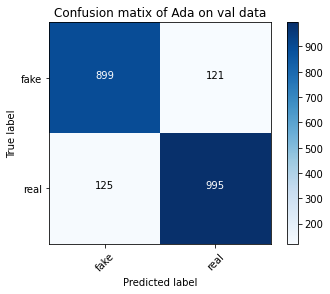

In [ ]:
# Ada
# display results
print_metrics(ada_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],ada_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ada on val data')

In [ ]:

# evaluate the model
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#n_scores = cross_val_score(ada_clf, tfidf_train,train['label'], scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
# report performance
#print('f1: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#doesn't work with f1 istead of accuracy :(

In [ ]:
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=ada_clf, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', verbose=10)
# execute the grid search
grid_result = grid_search.fit(tfidf_train,train['label'])
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 30 folds for each of 20 candidates, totalling 600 fits
Best: 0.896989 using {'learning_rate': 1.0, 'n_estimators': 500}
0.632399 (0.013223) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.632399 (0.013223) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.632399 (0.013223) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.632399 (0.013223) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.632399 (0.013223) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.632399 (0.013223) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.639616 (0.029860) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.719211 (0.017086) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.637747 (0.028872) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.719315 (0.017070) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.718847 (0.016905) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.807269 (0.014489) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.718847 (0.01

Fitting 30 folds for each of 20 candidates, totalling 600 fits
Best: 0.896989 using {'learning_rate': 1.0, 'n_estimators': 500}
0.632399 (0.013223) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.632399 (0.013223) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.632399 (0.013223) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.632399 (0.013223) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.632399 (0.013223) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.632399 (0.013223) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.639616 (0.029860) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.719211 (0.017086) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.637747 (0.028872) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.719315 (0.017070) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.718847 (0.016905) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.807269 (0.014489) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.718847 (0.016905) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.811475 (0.014774) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.835722 (0.013820) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.890654 (0.009529) with: {'learning_rate': 0.1, 'n_estimators': 500}
0.783126 (0.016256) with: {'learning_rate': 1.0, 'n_estimators': 10}
0.867861 (0.014094) with: {'learning_rate': 1.0, 'n_estimators': 50}
0.887331 (0.011666) with: {'learning_rate': 1.0, 'n_estimators': 100}
0.896989 (0.010805) with: {'learning_rate': 1.0, 'n_estimators': 500}